## ML Assignment 2 for Group-5
### data-set used :  [link](https://www.kaggle.com/jeevannagaraj/indian-liver-patient-dataset)

In [32]:
# imports used in the code 

import pandas as pd
import numpy as np
import random as rd
import math
import statistics
from matplotlib import pyplot as plt

# for calculating NMI value
from sklearn.metrics.cluster import normalized_mutual_info_score

# for calculating Silhouette score , ARI and Homogenity value
import sklearn.metrics

# import for calculationt the euclidian distance of data-points from the centroids
from scipy.spatial import distance

In [33]:
# Reading the data and creating dataframe
df = pd.read_csv("Indian Liver Patient Dataset (ILPD).csv")

# Gender had String values, so we replaced it by 0/1 values where Male = 1 and Female = 0
df["gender"]=(df["gender"]=="Male").astype(int)
# df.head()

In [34]:
X=df.iloc[:,:-1]
Y=df.iloc[:,-1]

# Some data in alkphos was missing so we replaced the missing data by the mean of all values in the column
X["alkphos"]=X["alkphos"].replace(np.NaN,X["alkphos"].mean())

# Normalize the features for better k-means performance 
for column in X.columns:
    X[column] = (X[column] - X[column].min()) / (X[column].max() - X[column].min())    

# X.head()

In [35]:
# This function is used for splitting the dataset as 80/20 split

def test_train_split(X,Y):
  p = np.random.permutation(len(X))
  split=int(0.8*len(X))
  return X[:split],Y[:split],X[split:],Y[split:]

K-means++ code for initializing k points:

In [36]:
def kmeanspp(X,K):

  # Randomly select the first cluster center from the data points and append it to the centroid matrix:
  i=rd.randint(0,X.shape[0])
  Centroid=np.array([X[i]])
  k_rows=np.array([i])

  # Loop for choosing other centroids:
  for k in range(1,K):

      # For each data point we calculate the square of Euclidian distance and append the minimum dist. to the "D" array 
      D=np.array([]) 
      for x in X:
          D=np.append(D,np.min(np.sum((x-Centroid)**2)))
      # Calculate probabilities of choosing the particular data point as the next centroid by dividing 
      # the Distance array(D) elements with the sum of Distance array and then take the cumulative PD
      prob=D/np.sum(D)
      cummulative_prob=np.cumsum(prob)

      # choose a random no. between 0 and 1.
      r=rd.random()
      i=0

      # choose the index of the Cumulative PD which is just greater than the chosen random number
      for j,p in enumerate(cummulative_prob):
          if r<p:
              i=j
              break
      
      # Assign the data point corressponding to this selected index
      k_rows=np.append(k_rows,[i],axis=0)

      # Add this point in our Centroids
      Centroid=np.append(Centroid,[X[i]],axis=0)
      
  # Finally return the Centroids and the selected rows
  return Centroid,k_rows

Initializing the centroid points for k-means algorithm :

In [37]:
def initialize_centroids(X,Y,k,init="default"):
    # X : dataset table of features, Y : results table
    X=X.values 
    Y=Y.values

    if init=="default":
      # Proceed with random initialization of K- centroids

      # choose k random centroids and store them in k_rows
      k_rows = np.random.choice(len(X)-1, k, replace=False)
      
      # all the centroid rows are assigned to the "centroids"
      centroids = X[k_rows, :]

    else:
      # Intialize K-Centroids using k-means++
      centroids,k_rows = kmeanspp(X,k)

    # We remove the centroid points from the dataset 
    X=np.delete(X,k_rows,0)
    Y=np.delete(Y,k_rows,0)

    # Return X, Y and the Centroid points for furthur calculations 
    return X,Y,centroids

### Function implementing the k-means algorithm :


In [38]:
# This function implements the k-means algorithm where "k" is given and we perform k-means (for maximum 
# of 100 iterations or until the centroids don't change in furthur iterations

def kmeans(X,Y,centroids,k,max_iterations=100):

    # splitting the data into 80:20 splits 
    # X_train, Y-train : Traning sets
    # X_test, Y-test : Testing sets
    X_train,Y_train,X_test,Y_test=test_train_split(X,Y)

    # P : Assign X_train points to different clusters based on the distance form the centroids
    P = np.argmin(distance.cdist(X_train, centroids, 'euclidean'),axis=1)
    
    for j in range(max_iterations):

        # update the centroids with the new centroids which is the mean of all points assigned 
        # to a cluster(from 1 to k) 
        centroids = np.vstack([(X_train[P==i,:].mean(axis=0) if len(X_train[P==i,:]) else np.zeros(X[0].shape))for i in range(k)])
        
        # updated_P : Assign X_train points to different clusters based on the distance form the new centroids
        updated_P = np.argmin(distance.cdist(X_train, centroids, 'euclidean'),axis=1)
        
        # break when the clusters don't change anymore to avoid unncesssary furthur computations
        if np.array_equal(P,updated_P):
            break
        P = updated_P

    # Storing the assigned clusters of the rows in the test_set
    result_of_test_set = np.argmin(distance.cdist(X_test, centroids, 'euclidean'),axis=1)

    # returning the X_test, Y_test and the final result of test_set so that we can furthur use these parameters to calculate Clustering
    # performance by NMI and Silhouette Index
    return X_test,Y_test,result_of_test_set

Take input from user for K and print the clustering performance with and without the ground truth :

In [39]:
k_userInput = int(input("Enter value of k :"))

# calling the kmeans function with the given k value by the user
X_new,Y_new,centroids=initialize_centroids(X,Y,k_userInput)
X_test,Y_test,result_of_test_set=kmeans(X_new,Y_new,centroids,k_userInput,100)

# Clustering Performace on the test split :
# Based on Ground truth is done using: NMI (Normalized Mutual Information) 
# Without the ground truth is done using : Silhoutte index

# NMI value :
NMI_value = normalized_mutual_info_score(Y_test,result_of_test_set)
print(f"NMI_value = {NMI_value}")

# Silhouette Score : 
model_silhouette_score= sklearn.metrics.silhouette_score(X_test,result_of_test_set,metric = 'euclidean')
print(f"Silouette score = {model_silhouette_score}")

# Homogenity_score :
Homogenity_score = sklearn.metrics.homogeneity_score(Y_test,result_of_test_set)
print(f"Homogenity score = {Homogenity_score}")

# ARI_value :
ARI_value = sklearn.metrics.adjusted_rand_score(Y_test,result_of_test_set)
print(f"ARI_value = {ARI_value}")

Enter value of k :6
NMI_value = 0.042405543884346
Silouette score = 0.15604696039806562
Homogenity score = 0.08360275086838378
ARI_value = 0.02129912277420856


###Code to get the most suitable K for the dataset:



In [40]:
# We will use silhoutte index to check for the performance for the k-means algorithm 
# and choose the best k for our dataset


# a list for storing the values of k taken (for graphical representation later)
k_list=[]

# a list for storing the Silhouette scores for the coressponding values of k taken (for graphical representation later)
silhouette_list=[]

# Looping for k value and choose the best 
for current_k in range(2,50):
    
    # add the k values in the k_list
    k_list.append(current_k)
    print(f"k = {current_k}")

    # call kmeans function for the current k value
    X_new,Y_new,centroids=initialize_centroids(X,Y,current_k)
    X_test,Y_test,result_of_test_set=kmeans(X_new,Y_new,centroids,current_k,100)

    # NMI value :
    # NMI_value = normalized_mutual_info_score(Y_test,result_of_test_set)
    # print(f"NMI_value = {NMI_value}")

    # Silhouette Score : 
    model_silhouette_score = sklearn.metrics.silhouette_score(X_test,result_of_test_set,metric = 'euclidean')
    print(f"Silouette score = {model_silhouette_score}")
    
    # append the silouette_score for the current_k value 
    silhouette_list.append(model_silhouette_score)


k = 2
Silouette score = 0.5351021493428149
k = 3
Silouette score = 0.27216858391521787
k = 4
Silouette score = 0.2809652504311503
k = 5
Silouette score = 0.14931972316560185
k = 6
Silouette score = 0.16239004521322106
k = 7
Silouette score = 0.12417419364147027
k = 8
Silouette score = 0.1875284060109293
k = 9
Silouette score = 0.13949414793254827
k = 10
Silouette score = 0.137265740994552
k = 11
Silouette score = 0.14624245656212229
k = 12
Silouette score = 0.06697575845722098
k = 13
Silouette score = 0.14543478889282485
k = 14
Silouette score = 0.08999903822621032
k = 15
Silouette score = 0.15527688690595357
k = 16
Silouette score = 0.13697813283652802
k = 17
Silouette score = 0.1371085736995378
k = 18
Silouette score = 0.11727487157113005
k = 19
Silouette score = 0.11173816390871964
k = 20
Silouette score = 0.12629525202918254
k = 21
Silouette score = 0.11263827144718311
k = 22
Silouette score = 0.10933960585521973
k = 23
Silouette score = 0.061573008374495655
k = 24
Silouette score 

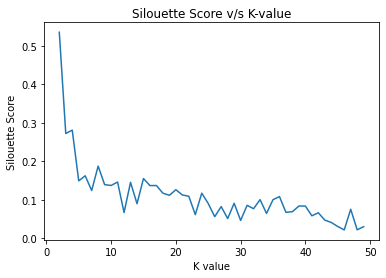

In [41]:
# Plotting the Silouette score v/s k plot:

plt.plot(k_list,silhouette_list)
plt.xlabel("K value")
plt.ylabel("Silouette Score")
plt.title("Silouette Score v/s K-value")
plt.show()

#### Clustering Outcomes when k is randomly initailaized v/s when we use kmeans++ for initialization:

In [42]:
'''
1. select K random points from the original data
2. split remaining data into 2 parts randomly (80:20) ratio
3. apply k-means on training data with K-random points selected in step-1
4. label test data using k-centroids.
5. use some metric(NMI,ARI, etc.) in test data to understand clustering accuracy
6. repeat 2-5 at least 50 times and report average metric
'''


# Calculating the NMI/ARI/Homogenity/Silhouette values with both ways of initialization of k centroids
# In this case we have taken k = 2

k=2  # You can procees if you want to take any other k value, we proceeded with 2 beacuse it was thw best K value we were getting above

# Putting the values of NMI/ARI/Homogenity/Silhouette for plotting of their mean values over the 50 random k points 
# and 50 Kmeans++ points


# Lists to store the various metric values for plotting and anlaysing purpose :

NMI_random_list=[]
NMI_pp_list=[]
ARI_random_list=[]
ARI_pp_list=[]
Homogenity_random_list=[]
Homogenity_pp_list=[]
Silhouette_random_list=[]
Silhouette_pp_list=[]

# ============== Random Initialization ==============

for _ in range(50):
    NMI_dict={"NMI":[]}
    ARI_dict={"ARI":[]}
    Homogenity_dict={"Homogenity":[]}
    Silhouette_dict={"Silhouette":[]}
    
    # Step 1
    X_new,Y_new,centroids=initialize_centroids(X,Y,k)

    # Repeating steps 2-5, 50 times
    for _ in range(50):
      X_test,Y_test,result_of_test_set=kmeans(X_new,Y_new,centroids,k,100)
      NMI_dict["NMI"].append(normalized_mutual_info_score(Y_test,result_of_test_set))
      ARI_dict["ARI"].append(sklearn.metrics.adjusted_rand_score(Y_test,result_of_test_set))
      Homogenity_dict["Homogenity"].append(sklearn.metrics.homogeneity_score(Y_test,result_of_test_set))
      Silhouette_dict["Silhouette"].append(sklearn.metrics.silhouette_score(X_test,result_of_test_set,metric = 'euclidean'))

    # The .describe() can let us know any value like mean, min, max if we want in later stages or just want to see data results :

    NMI_random_list.append(pd.DataFrame(NMI_dict)["NMI"].describe())
    ARI_random_list.append(pd.DataFrame(ARI_dict)["ARI"].describe())
    Homogenity_random_list.append(pd.DataFrame(Homogenity_dict)["Homogenity"].describe())
    Silhouette_random_list.append(pd.DataFrame(Silhouette_dict)["Silhouette"].describe())




# ============== K-means++ Initialization ==============

for _ in range(50):

    NMI_dict={"NMI":[]}
    ARI_dict={"ARI":[]}
    Homogenity_dict={"Homogenity":[]}
    Silhouette_dict={"Silhouette":[]}

    # Step 1
    X_new,Y_new,centroids=initialize_centroids(X,Y,k,init="kmeans++")

    # Repeating steps 2-5, 50 times
    for _ in range(50):
      X_test,Y_test,result_of_test_set=kmeans(X_new,Y_new,centroids,k,100)
      NMI_dict["NMI"].append(normalized_mutual_info_score(Y_test,result_of_test_set))
      ARI_dict["ARI"].append(sklearn.metrics.adjusted_rand_score(Y_test,result_of_test_set))
      Homogenity_dict["Homogenity"].append(sklearn.metrics.homogeneity_score(Y_test,result_of_test_set))
      Silhouette_dict["Silhouette"].append(sklearn.metrics.silhouette_score(X_test,result_of_test_set,metric = 'euclidean'))
    
    # The .describe() can let us know any value like mean, min, max if we want in later stages or just want to see data results :
    
    NMI_pp_list.append(pd.DataFrame(NMI_dict)["NMI"].describe())
    ARI_pp_list.append(pd.DataFrame(ARI_dict)["ARI"].describe())
    Homogenity_pp_list.append(pd.DataFrame(Homogenity_dict)["Homogenity"].describe())
    Silhouette_pp_list.append(pd.DataFrame(Silhouette_dict)["Silhouette"].describe())





Dispersion : 
random_max_NMI = 0.05953283021330544
random_min_NMI = 0.04374193068377192
random_mean_NMI = 0.04567584670131092


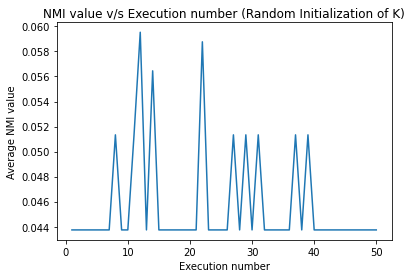

Dispersion : 
kmeanspp_max_NMI = 0.05953283021330544
kmeanspp_min_NMI = 0.04374193068377192
kmeanspp_mean_NMI = 0.04691840746604097


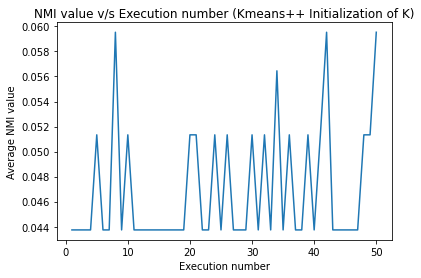

In [47]:
# NMI results for :

# Random initializations :

print("Dispersion : ")
random_max_NMI = max([x["mean"] for x in NMI_random_list])
random_min_NMI = min([x["mean"] for x in NMI_random_list])
random_mean_NMI = statistics.mean([x["mean"] for x in NMI_random_list])

print(f"random_max_NMI = {random_max_NMI}")
print(f"random_min_NMI = {random_min_NMI}")
print(f"random_mean_NMI = {random_mean_NMI}")

plt.plot([i+1 for i in range(50)],[x["mean"] for x in NMI_random_list])
plt.xlabel("Execution number")
plt.ylabel("Average NMI value")
plt.title("NMI value v/s Execution number (Random Initialization of K)")
plt.show()

# Kmeans++ initializations :

print("Dispersion : ")
kmeanspp_max_NMI = max([x["mean"] for x in NMI_pp_list])
kmeanspp_min_NMI = min([x["mean"] for x in NMI_pp_list])
kmeanspp_mean_NMI = statistics.mean([x["mean"] for x in NMI_pp_list])

print(f"kmeanspp_max_NMI = {kmeanspp_max_NMI}")
print(f"kmeanspp_min_NMI = {kmeanspp_min_NMI}")
print(f"kmeanspp_mean_NMI = {kmeanspp_mean_NMI}")

plt.plot([i+1 for i in range(50)],[x["mean"] for x in NMI_pp_list])
plt.xlabel("Execution number")
plt.ylabel("Average NMI value")
plt.title("NMI value v/s Execution number (Kmeans++ Initialization of K)")
plt.show()

Dispersion : 
random_max_Homogenity = 0.05386635231218007
random_min_Homogenity = 0.03967308820753225
random_mean_Homogenity = 0.04147929887518107


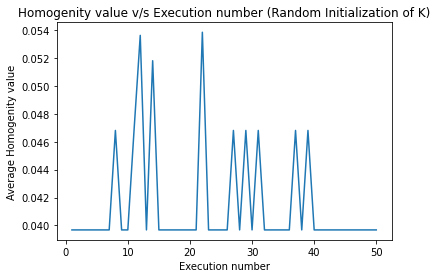

Dispersion : 
kmeanspp_max_Homogenity = 0.053642681787040285
kmeanspp_min_Homogenity = 0.03967308820753225
kmeanspp_mean_Homogenity = 0.04261134045425048


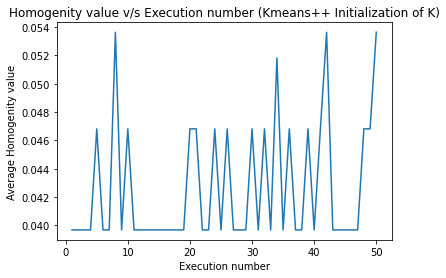

In [48]:
# Homogenity results for :

# Random initializations :

print("Dispersion : ")

random_max_Homogenity = max([x["mean"] for x in Homogenity_random_list])
random_min_Homogenity = min([x["mean"] for x in Homogenity_random_list])
random_mean_Homogenity = statistics.mean([x["mean"] for x in Homogenity_random_list])

print(f"random_max_Homogenity = {random_max_Homogenity}")
print(f"random_min_Homogenity = {random_min_Homogenity}")
print(f"random_mean_Homogenity = {random_mean_Homogenity}")


plt.plot([i+1 for i in range(50)],[x["mean"] for x in Homogenity_random_list])
plt.xlabel("Execution number")
plt.ylabel("Average Homogenity value")
plt.title("Homogenity value v/s Execution number (Random Initialization of K)")
plt.show()

# Kmeans++ initializations :

print("Dispersion : ")
kmeanspp_max_Homogenity = max([x["mean"] for x in Homogenity_pp_list])
kmeanspp_min_Homogenity = min([x["mean"] for x in Homogenity_pp_list])
kmeanspp_mean_Homogenity = statistics.mean([x["mean"] for x in Homogenity_pp_list])

print(f"kmeanspp_max_Homogenity = {kmeanspp_max_Homogenity}")
print(f"kmeanspp_min_Homogenity = {kmeanspp_min_Homogenity}")
print(f"kmeanspp_mean_Homogenity = {kmeanspp_mean_Homogenity}")

plt.plot([i+1 for i in range(50)],[x["mean"] for x in Homogenity_pp_list])
plt.xlabel("Execution number")
plt.ylabel("Average Homogenity value")
plt.title("Homogenity value v/s Execution number (Kmeans++ Initialization of K)")
plt.show()

Dispersion : 
random_max_Silhouette = 0.5379723290013212
random_min_Silhouette = 0.5350405386374878
random_mean_Silhouette = 0.5369234376860865


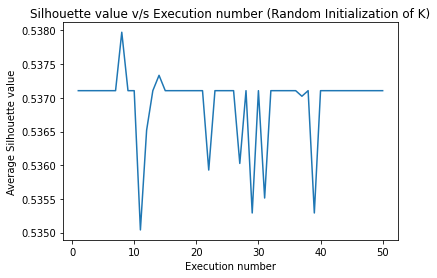

Dispersion : 
kmeanspp_max_Silhouette = 0.5401420662758872
kmeanspp_min_Silhouette = 0.5352445889900314
kmeanspp_mean_Silhouette = 0.5372240370423559


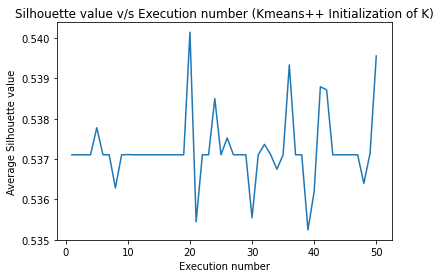

In [49]:
# Silhouette results for :

# Random initializations :

print("Dispersion : ")

random_max_Silhouette = max([x["mean"] for x in Silhouette_random_list])
random_min_Silhouette = min([x["mean"] for x in Silhouette_random_list])
random_mean_Silhouette = statistics.mean([x["mean"] for x in Silhouette_random_list])

print(f"random_max_Silhouette = {random_max_Silhouette}")
print(f"random_min_Silhouette = {random_min_Silhouette}")
print(f"random_mean_Silhouette = {random_mean_Silhouette}")


plt.plot([i+1 for i in range(50)],[x["mean"] for x in Silhouette_random_list])
plt.xlabel("Execution number")
plt.ylabel("Average Silhouette value")
plt.title("Silhouette value v/s Execution number (Random Initialization of K)")
plt.show()

# Kmeans++ initializations :

print("Dispersion : ")

kmeanspp_max_Silhouette = max([x["mean"] for x in Silhouette_pp_list])
kmeanspp_min_Silhouette = min([x["mean"] for x in Silhouette_pp_list])
kmeanspp_mean_Silhouette = statistics.mean([x["mean"] for x in Silhouette_pp_list])

print(f"kmeanspp_max_Silhouette = {kmeanspp_max_Silhouette}")
print(f"kmeanspp_min_Silhouette = {kmeanspp_min_Silhouette}")
print(f"kmeanspp_mean_Silhouette = {kmeanspp_mean_Silhouette}")

plt.plot([i+1 for i in range(50)],[x["mean"] for x in Silhouette_pp_list])
plt.xlabel("Execution number")
plt.ylabel("Average Silhouette value")
plt.title("Silhouette value v/s Execution number (Kmeans++ Initialization of K)")
plt.show()

Dispersion : 
random_max_ARI = 0.14547794917836554
random_min_ARI = 0.12200217478787241
random_mean_ARI = 0.12472952163060995


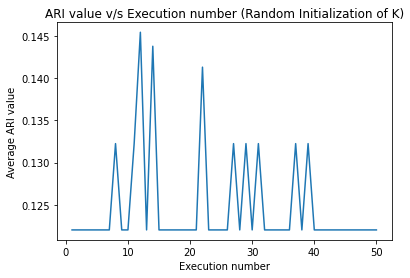

Dispersion : 
kmeanspp_max_ARI = 0.14547794917836554
kmeanspp_min_ARI = 0.12200217478787241
kmeanspp_mean_ARI = 0.12651193022377719


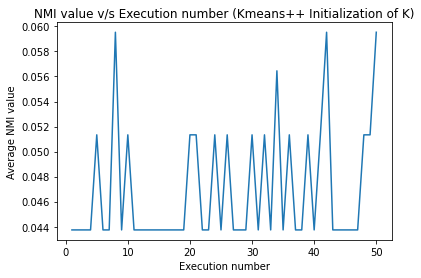

In [50]:
# ARI results for :

# Random initializations :

print("Dispersion : ")

random_max_ARI = max([x["mean"] for x in ARI_random_list])
random_min_ARI = min([x["mean"] for x in ARI_random_list])
random_mean_ARI = statistics.mean([x["mean"] for x in ARI_random_list])

print(f"random_max_ARI = {random_max_ARI}")
print(f"random_min_ARI = {random_min_ARI}")
print(f"random_mean_ARI = {random_mean_ARI}")


plt.plot([i+1 for i in range(50)],[x["mean"] for x in ARI_random_list])
plt.xlabel("Execution number")
plt.ylabel("Average ARI value")
plt.title("ARI value v/s Execution number (Random Initialization of K)")
plt.show()

# Kmeans++ initializations :

print("Dispersion : ")

kmeanspp_max_ARI = max([x["mean"] for x in ARI_pp_list])
kmeanspp_min_ARI = min([x["mean"] for x in ARI_pp_list])
kmeanspp_mean_ARI = statistics.mean([x["mean"] for x in ARI_pp_list])

print(f"kmeanspp_max_ARI = {kmeanspp_max_ARI}")
print(f"kmeanspp_min_ARI = {kmeanspp_min_ARI}")
print(f"kmeanspp_mean_ARI = {kmeanspp_mean_ARI}")

plt.plot([i+1 for i in range(50)],[x["mean"] for x in NMI_pp_list])
plt.xlabel("Execution number")
plt.ylabel("Average NMI value")
plt.title("NMI value v/s Execution number (Kmeans++ Initialization of K)")
plt.show()